In [266]:
import xarray_beam as xb

ds, chunk = xb.open_zarr('gcs://era5_climate/1440x720/2019-12-31_2021-12-31.zarr')

In [224]:
print(ds.nbytes / (10**9))

24.72148344


In [251]:
print(chunk)

{'time': 1, 'latitude': 721, 'longitude': 1440, 'level': 37}


In [267]:
print(ds)

<xarray.Dataset>
Dimensions:                       (time: 17545, latitude: 64, longitude: 64,
                                   level: 13)
Coordinates:
  * latitude                      (latitude) float32 27.0 27.25 ... 42.5 42.75
  * level                         (level) int64 50 100 150 200 ... 850 925 1000
  * longitude                     (longitude) float32 119.2 119.5 ... 135.0
  * time                          (time) datetime64[ns] 2019-12-31 ... 2021-1...
Data variables: (12/15)
    10m_u_component_of_wind       (time, latitude, longitude) float32 ...
    10m_v_component_of_wind       (time, latitude, longitude) float32 ...
    2m_temperature                (time, latitude, longitude) float32 ...
    geopotential                  (time, level, latitude, longitude) float32 ...
    land_sea_mask                 (latitude, longitude) float32 ...
    mean_sea_level_pressure       (time, latitude, longitude) float32 ...
    ...                            ...
    toa_incident_solar_

In [268]:
import numpy as np
import pandas as pd

lat_min, lat_max = (27, 42.8)
lon_min, lon_max = (119.2, 135)

lat_indices = np.where((ds.latitude >= lat_min) & (ds.latitude <= lat_max))[0]
lon_indices = np.where((ds.longitude >= lon_min) & (ds.longitude <= lon_max))[0]

print(lat_indices)

start_date = pd.to_datetime('2021-12-28')
end_date = pd.to_datetime('2021-12-29')
source_dataset = ds.sel(time=slice(start_date, end_date))

print(source_dataset)



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
<xarray.Dataset>
Dimensions:                       (time: 25, latitude: 64, longitude: 64,
                                   level: 13)
Coordinates:
  * latitude                      (latitude) float32 27.0 27.25 ... 42.5 42.75
  * level                         (level) int64 50 100 150 200 ... 850 925 1000
  * longitude                     (longitude) float32 119.2 119.5 ... 135.0
  * time                          (time) datetime64[ns] 2021-12-28 ... 2021-1...
Data variables: (12/15)
    10m_u_component_of_wind       (time, latitude, longitude) float32 ...
    10m_v_component_of_wind       (time, latitude, longitude) float32 ...
    2m_temperature                (time, latitude, longitude) float32 ...
    geopotential                  (time, level, latitude, longitude) float32 ...
    land_se

In [269]:
print(source_dataset.dims)

FrozenMappingWarningOnValuesAccess({'time': 25, 'latitude': 64, 'longitude': 64, 'level': 13})


In [270]:
dataset = source_dataset[''].values
filt = dataset[:, lat_indices, :][:, :, lon_indices]

(64, 64)


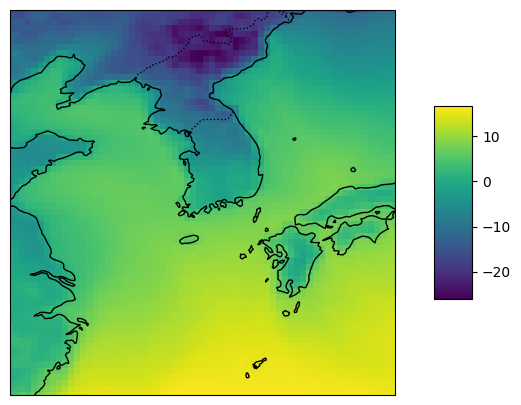

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 예제 NumPy 배열 생성
data = dataset[0] - 273.15
print(data.shape)

# 지도 생성 및 데이터 시각화
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 지도에 기본 레이어 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# NumPy 배열을 지도 위에 표시 (임의의 위경도 범위에 맞게 조정)
lons = np.linspace(lon_min, lon_max, data.shape[1])
lats = np.linspace(lat_min, lat_max, data.shape[0])
Lons, Lats = np.meshgrid(lons, lats)
mesh = ax.pcolormesh(Lons, Lats, data, transform=ccrs.PlateCarree())

plt.colorbar(mesh, ax=ax, shrink=0.5, aspect=5)

plt.show()

In [27]:
import torch

def get_tgt_mask(var_len, tgt_time_len) -> torch.tensor:
        matrix = torch.zeros(var_len * tgt_time_len, var_len * tgt_time_len)

        for i in range(tgt_time_len):
            for j in range(var_len):
                inf_idx = min(((i)*var_len), var_len * tgt_time_len)
                matrix[:(i*var_len), inf_idx:] = float('-inf')
        return matrix


print(get_tgt_mask(3, 5))

tensor([[0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,